In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df05 = pd.read_csv('NY_taxi_may.csv')

In [3]:
df05.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,region
0,0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,...,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80,1233
1,1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,...,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68,1180
2,2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,...,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36,1180
3,3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,...,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96,1173
4,4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,...,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76,1130


In [4]:
regions = pd.read_csv('regions.csv', sep = ';')

In [5]:
regions_range = np.arange(1, 2501)
all_regions = pd.DataFrame()
all_regions["region"] = regions_range
all_regions["counts"] = 0

region_notzero = df05["region"].value_counts()
region_notzero = (region_notzero).to_frame()
region_notzero.columns = ['counts']
region_notzero.index.name = 'region'
region_notzero = region_notzero.sort_values(by=['region'])
region_notzero.reset_index(level=0, inplace=True)

regions_all_data = pd.merge_asof(all_regions, region_notzero, on='region', by = ['region'])

regions_all_data = regions_all_data.fillna(0)
regions_all_data = regions_all_data.drop(["counts_x"], axis = 1)
regions_all_data = regions_all_data.rename(columns={'counts_y': 'counts'})

In [6]:
regions_all_data["average_per_hour"] = regions_all_data["counts"]/744

In [7]:
regions_best = regions_all_data[regions_all_data.average_per_hour > 5]

In [8]:
regions_best[regions_best.region == 1231]

,region,counts,average_per_hour
1230,1231,489489.0,657.915323


    1. Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. Не используйте данные за последний имеющийся месяц — июнь 2016! Создайте регрессионные признаки для учёта сезонностей и трендов.

In [9]:
data = df05[df05.region == 1231]

In [10]:
type(data.tpep_pickup_datetime)

pandas.core.series.Series

In [11]:
import datetime

In [12]:
import warnings

warnings.filterwarnings("ignore")

data.tpep_pickup_datetime = pd.to_datetime(data.tpep_pickup_datetime)

In [13]:
data['group_pickup_datetime'] = map(lambda x: x.replace(second =0, minute = 0), data.tpep_pickup_datetime)

In [14]:
group_count = data[['group_pickup_datetime', 'region', 'VendorID']].groupby(['group_pickup_datetime', 'region']).count().reset_index()

In [15]:
group_count.head()

,group_pickup_datetime,region,VendorID
0,2016-05-01 00:00:00,1231,881
1,2016-05-01 01:00:00,1231,713
2,2016-05-01 02:00:00,1231,533
3,2016-05-01 03:00:00,1231,418
4,2016-05-01 04:00:00,1231,353


Text(0.5,1,'Number of trips from EBS region in time')

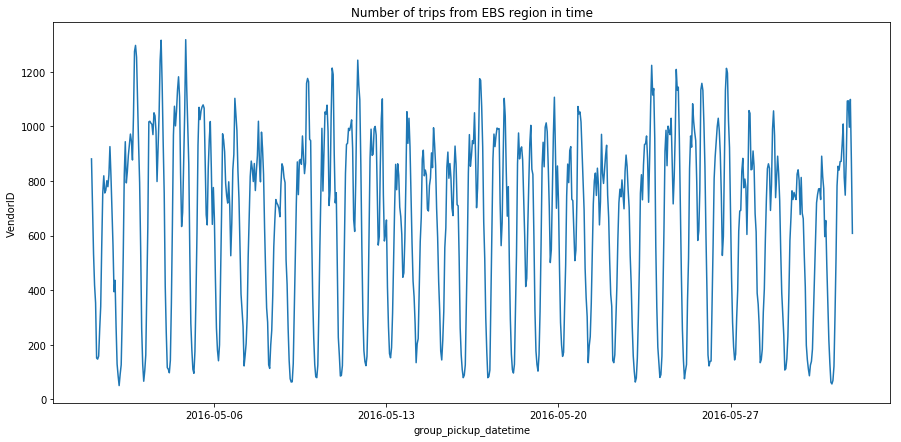

In [16]:
plt.figure(figsize=(15,7))

sns.lineplot(x = 'group_pickup_datetime', y = 'VendorID', data = group_count).set_title('Number of trips from EBS region in time')

Здесь будем в первом приближении работать ТОЛЬКО С ДАННЫМИ ЗА МАЙ 2016, агрегированными за час. В них есть уже несколько видов сезонности: дневная и недельная

Для учёта недельной сезонности используются регрессионные признаки следующего вида:

$$s_i = \sin \left( [1,\dots,T] * 2 \pi i/ 168 \right),$$
$$c_i = \cos \left( [1,\dots,T] * 2 \pi i/ 168 \right), i=1,\dots, K.$$


Здесь T — это длина моделируемого ряда, 168 — длительность недели в часах, а значение параметра K вам предстоит подобрать самостоятельно (в зависимости от длины подготовленного ряда, можно для начала взять K равным 2-5).

Если вы собрали данные за несколько лет, аналогичные признаки можно использовать для учёта годовой сезонности. Длина года — 8766 часов.

Если в данных есть линейный или описываемый ещё какой-то простой функцией ff тренд, стоит добавить к регрессионным признакам вектор $[1,\dots,T]$ или, соответственно, $f([1,\dots,T])$.

In [17]:
group_count = group_count.sort_values('group_pickup_datetime')

In [18]:
group_count['i'] = group_count.index

In [19]:
import math

In [20]:
group_count['s1'] = map(lambda x: math.sin(x*2*math.pi*1/168.0), group_count.i)

In [21]:
group_count['s2'] = map(lambda x: math.sin(x*2*math.pi*2/168.0), group_count.i)

In [22]:
group_count['s3'] = map(lambda x: math.sin(x*2*math.pi*3/168.0), group_count.i)

In [23]:
group_count['c1'] = map(lambda x: math.cos(x*2*math.pi*1/168.0), group_count.i)

In [24]:
group_count['c2'] = map(lambda x: math.cos(x*2*math.pi*2/168.0), group_count.i)

In [25]:
group_count['c3'] = map(lambda x: math.cos(x*2*math.pi*3/168.0), group_count.i)

    2. Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.

In [26]:
import statsmodels.formula.api as smf

In [27]:
# line_model = smf.ols('VendorID ~ s1 + s2 + s3 + c1 + c2 + c3', 
#              data=group_count)

line_model = smf.ols('VendorID ~ s1 + c1', 
             data=group_count)

line_fitted = line_model.fit()
print line_fitted.summary()

                            OLS Regression Results                            
Dep. Variable:               VendorID   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     8.817
Date:                Tue, 18 Dec 2018   Prob (F-statistic):           0.000164
Time:                        20:52:34   Log-Likelihood:                -5339.9
No. Observations:                 744   AIC:                         1.069e+04
Df Residuals:                     741   BIC:                         1.070e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    660.0351     11.695     56.437      0.0

In [28]:
import matplotlib.pyplot as plt

In [29]:
group_count['line_fitted']= line_fitted.fittedvalues

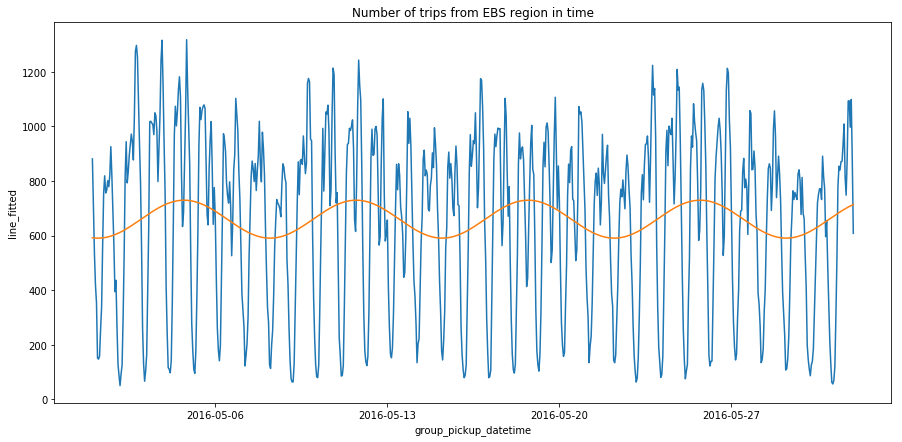

In [30]:
plt.figure(figsize=(15,7))

sns.lineplot(x = 'group_pickup_datetime', y = 'VendorID', data = group_count).set_title('Number of trips from EBS region in time')

sns.lineplot(x = 'group_pickup_datetime', y = 'line_fitted', data = group_count) 

Populating the interactive namespace from numpy and matplotlib


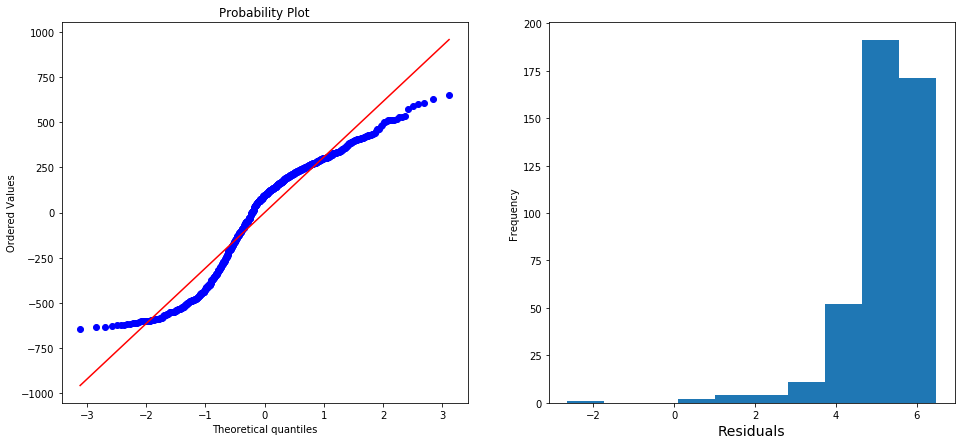

In [31]:
import scipy as sc
%pylab inline
plt.figure(figsize(16,7))

plt.subplot(121)
sc.stats.probplot(line_fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(line_fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

In [32]:
group_count['line_resid'] = line_fitted.resid

Text(0.5,1,'Residuals')

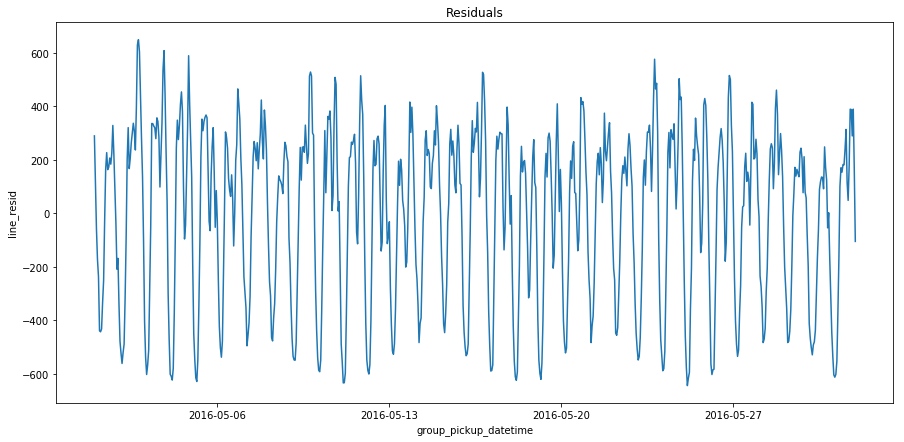

In [33]:
plt.figure(figsize=(15,7))

sns.lineplot(x = 'group_pickup_datetime', y = 'line_resid', data = group_count).set_title('Residuals')



По моему скромному мнению лучше всего недельную сезонность описывает модель с s1 и c1 только 

    3. Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.

In [34]:
import statsmodels.api as sm

In [35]:
decompose_data = pd.DataFrame(data = {'line_resid': np.asarray(group_count.line_resid)},
                              index = group_count.group_pickup_datetime)

Критерий Дики-Фуллера: p=0.000004


<Figure size 1080x720 with 0 Axes>

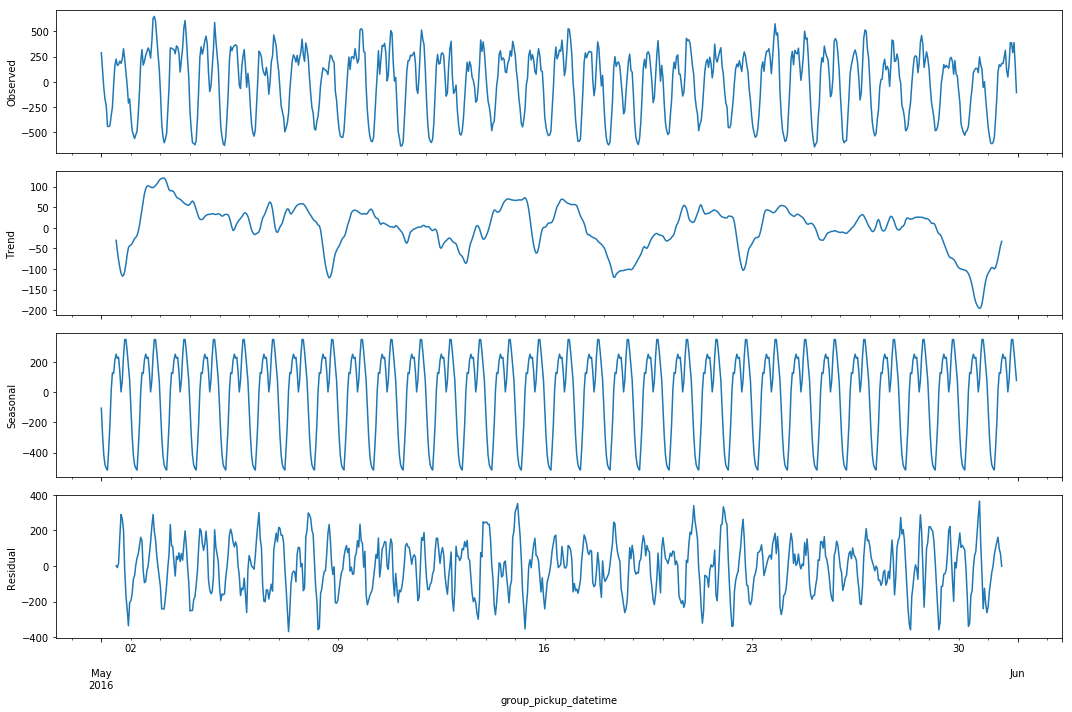

In [36]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(decompose_data.line_resid).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(decompose_data.line_resid)[1])

Остатки модели и правда выглядят стационарными, что подтверждает критерий Дики-Фуллера

    4. Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров p, q, P, Qp,q,P,Q. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.

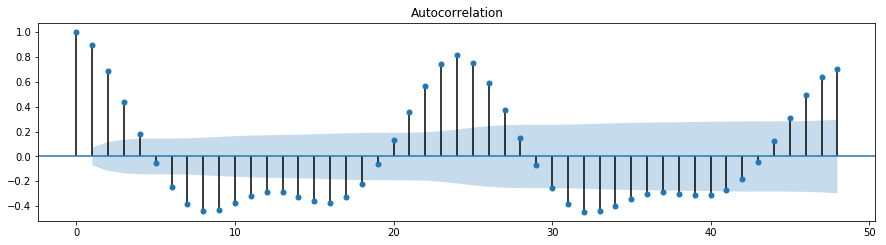

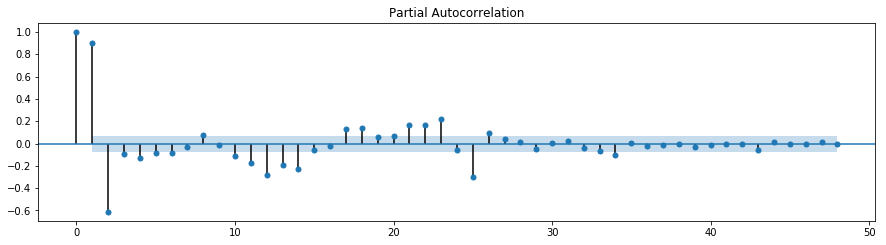

In [37]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(decompose_data.line_resid.values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(decompose_data.line_resid.values.squeeze(), lags=48, ax=ax)
pylab.show()

По полученным данным с дневной сезонностью (S = 24) можем взять следующие приближения для параметров модели

In [38]:
Q = 4

q = 23

P = 1

p = 23

Соответвенно 

In [50]:
ps = range(0, 23)
d=0
qs = range(0, 23)
Ps = range(0, 4)
D=0
Qs = range(0, 4)

Но так как такое огромное число наборов параметров обещает обрабатываться за более чем 2е суток, поступим скромнее и обучим модель на меньших параметрах

In [66]:
ps = range(0, 4)
d=0
qs = range(0, 4)
Ps = range(0, 4)
D=0
Qs = range(0, 4)

In [51]:
from itertools import product

In [67]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

256

In [64]:
from tqdm import tqdm_notebook 

In [68]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm_notebook(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(group_count.VendorID.astype("float64"), 
                                        exog = np.asarray(group_count[['c1','s1']]),
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except LinAlgError:
        print 'wrong parameters (LinAlgError):', param
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')


HBox(children=(IntProgress(value=0, max=256), HTML(value=u'')))

('wrong parameters:', (0, 0, 0, 0))
wrong parameters (LinAlgError): (0, 0, 1, 1)
('wrong parameters:', (0, 0, 1, 3))
('wrong parameters:', (0, 0, 2, 3))
('wrong parameters:', (0, 1, 0, 0))
('wrong parameters:', (0, 1, 0, 1))
('wrong parameters:', (0, 1, 0, 2))
('wrong parameters:', (0, 1, 0, 3))
('wrong parameters:', (0, 1, 1, 0))
('wrong parameters:', (0, 1, 1, 1))
('wrong parameters:', (0, 1, 1, 2))
('wrong parameters:', (0, 1, 1, 3))
('wrong parameters:', (0, 1, 2, 0))
('wrong parameters:', (0, 1, 2, 1))
('wrong parameters:', (0, 1, 2, 2))
('wrong parameters:', (0, 1, 2, 3))
('wrong parameters:', (0, 1, 3, 0))
('wrong parameters:', (0, 1, 3, 1))
('wrong parameters:', (0, 1, 3, 2))
('wrong parameters:', (0, 1, 3, 3))
('wrong parameters:', (0, 2, 0, 0))
('wrong parameters:', (0, 2, 0, 1))
('wrong parameters:', (0, 2, 0, 2))
('wrong parameters:', (0, 2, 0, 3))
('wrong parameters:', (0, 2, 1, 0))
('wrong parameters:', (0, 2, 1, 1))
('wrong parameters:', (0, 2, 1, 2))
('wrong parameters:

In [72]:
results

[[(0, 0, 0, 1), 11124.948605490987],
 [(0, 0, 0, 2), 11020.13386497876],
 [(0, 0, 0, 3), 11020.678968307644],
 [(0, 0, 1, 0), 9884.33272915805],
 [(0, 0, 1, 2), 9718.214712114765],
 [(0, 0, 2, 0), 9870.659007752784],
 [(0, 0, 2, 1), 9794.911104354353],
 [(0, 0, 2, 2), 9814.194579226254],
 [(0, 0, 3, 0), 9853.021565184183],
 [(0, 0, 3, 1), 9713.391523983319],
 [(0, 0, 3, 2), 9761.282273099556],
 [(0, 0, 3, 3), 9865.947838739643],
 [(1, 0, 0, 0), 9497.70127229629],
 [(1, 0, 0, 1), 9185.416235541987],
 [(1, 0, 0, 2), 9053.546107377395],
 [(1, 0, 0, 3), 9031.675633803487],
 [(1, 0, 1, 0), 8941.818987833514],
 [(1, 0, 1, 1), 8837.845908969573],
 [(1, 0, 1, 2), 8795.217112120281],
 [(1, 0, 2, 0), 8915.391906082594],
 [(1, 0, 2, 1), 8794.944685354476],
 [(1, 0, 2, 2), 8799.140094648545],
 [(1, 0, 3, 0), 8913.943969658252],
 [(1, 0, 3, 1), 8791.495900549653],
 [(1, 0, 3, 2), 8798.907673171005],
 [(1, 0, 3, 3), 8831.402384373585],
 [(1, 1, 0, 0), 9273.60741455742],
 [(1, 1, 0, 1), 9065.81611378

In [74]:
best_param

(3, 1, 3, 3)

    5. Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов KK или поменять порядки дифференцирования.

In [75]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           VendorID   No. Observations:                  744
Model:             SARIMAX(3, 0, 1)x(3, 0, 3, 24)   Log Likelihood               -4345.711
Date:                            Thu, 27 Dec 2018   AIC                           8717.422
Time:                                    20:09:02   BIC                           8777.378
Sample:                                01-01-1970   HQIC                          8740.533
                                     - 01-01-1970                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -46.1433     25.319     -1.822      0.068     -95.767       3.481
x2            73.7212     30.186   

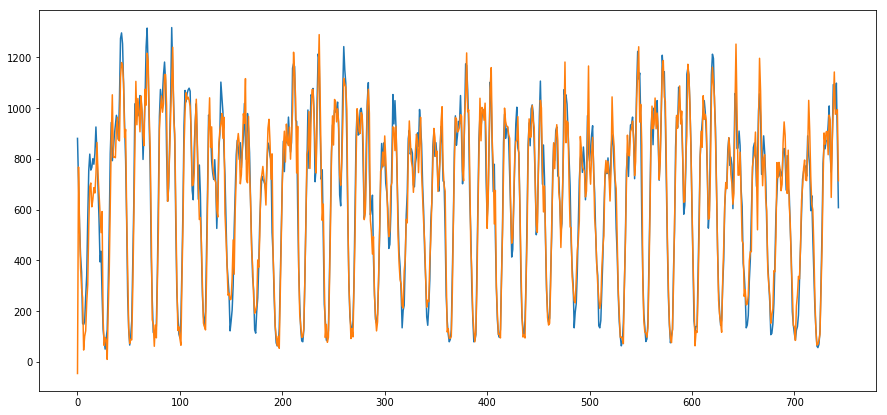

In [85]:
plt.figure(figsize(15,7))
group_count.VendorID.plot()
best_model.fittedvalues.plot()

# best_model.predict(start=700, end=850).plot(color='r')

pylab.show()

В общем-то выглядит приличнее, чем можно было ожидать

    6. Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

Данная модель наверняка плохо описывает меясчную и годовую сезонность. Для того, чтобы улучшить прогноз необходимо взять больший вреенной промежуток данных и иметь большие вычислительные мощности для их обработки. 

Имеющуюся сезонность: недельную и дневную, модель описывает достаточно хорошо. Проанализируем остатки модели

Критерий Стьюдента: p=0.232900
Критерий Дики-Фуллера: p=0.000000


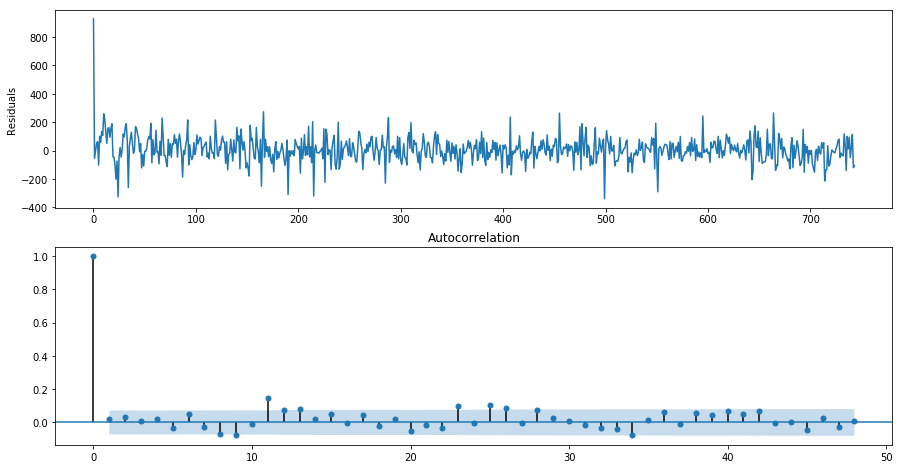

In [87]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

from scipy import stats

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается коррелограммой). 